## uncooperative-distributed-writes
Example notebook writing atomic units of 30m conus to Icechunk using the uncooperative distributed write strategy.
Note: Shares tons of overlapping code with `cooperative-distributed-writes`

In [1]:
import tempfile

import dask
import icechunk
import matplotlib.style as mplstyle
import numpy as np
import xarray as xr
from distributed import Client

from ocr.chunking_config import ChunkingConfig

mplstyle.use('fast')

In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://cluster-pjtmf.dask.host/jupyter/proxy/8787/status,
Dashboard: https://cluster-pjtmf.dask.host/jupyter/proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 30.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41735,Workers: 8
Dashboard: https://cluster-pjtmf.dask.host/jupyter/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 30.15 GiB
Comm: tcp://127.0.0.1:42551,Total threads: 1
Dashboard: https://cluster-pjtmf.dask.host/jupyter/proxy/40335/status,Memory: 3.77 GiB
Nanny: tcp://127.0.0.1:36381,


In [3]:
config = ChunkingConfig()
config

<POLYGON ((2327640 221280, 2327640 3267390, -2362380 3267390, -2362380 22128...>

In [4]:
storage = icechunk.s3_storage(
    bucket='carbonplan-ocr',
    prefix='input/fire-risk/tensor/USFS/RDS-2022-0016-02_all_vars_merge_icechunk',
    from_env=True,
)


repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')
ds = xr.open_zarr(session.store, consolidated=False, chunks={})[['BP']]
ds['BP'] = ds['BP'].astype('float32')
ds['BP'].encoding = {}

In [5]:
zarr_chunks = config.chunks
template = xr.Dataset(config.ds.coords).drop_vars('spatial_ref')
template['BP'] = xr.DataArray(
    dask.array.zeros(
        (config.ds.sizes['y'], config.ds.sizes['x']),
        dtype='float32',
        chunks=-1,
    ),
    dims=('y', 'x'),
)

In [6]:
store_path = tempfile.TemporaryDirectory().name
storage = icechunk.local_filesystem_storage(store_path)
repo = icechunk.Repository.create(storage)
session = repo.writable_session('main')

template.to_zarr(
    session.store,
    compute=False,
    mode='w',
    encoding={
        'BP': {'chunks': ((config.chunks['x'], config.chunks['y'])), 'fill_value': np.nan}
    },  # IMPORTANT
    consolidated=False,
)

session.commit('template')

'079PAN9Z32WJZ4X8EPCG'

In [ ]:
def get_commit_messages_ancestry(repo: icechunk.repository) -> list:
    return [commit.message for commit in list(repo.ancestry(branch='main'))]


@dask.delayed
def insert_region_uncoop(store_path: str, subset_ds: xr.Dataset, region_id: str):
    storage = icechunk.local_filesystem_storage(store_path)
    repo = icechunk.Repository.open(storage)

    while True:
        try:
            session = repo.writable_session('main')
            subset_ds.to_zarr(
                session.store,
                region='auto',
                consolidated=False,
            )

            session.commit(f'{region_id}')
            print(f'Wrote region: {region_id}')
            break

        except icechunk.ConflictError:
            print(f'conflict for region_commit_history {region_id}, retrying')
            pass


def return_ds_subsets_from_region_dict(ds: xr.Dataset, region_dict: dict) -> dict:
    return {
        region_id: ds.isel(x=x_slice, y=y_slice)
        for region_id, (x_slice, y_slice) in region_dict.items()
    }


def filter_region_duplicates(repo: icechunk.Repository, region_dict) -> dict:
    commit_messages = get_commit_messages_ancestry(repo)
    already_commited_messages = [
        msg
        for message in commit_messages
        for msg in (message.split(',') if ',' in message else [message])
    ]
    # uncommited dict
    uncommited_dict = {
        key: subset for key, subset in region_dict.items() if key not in already_commited_messages
    }
    if not uncommited_dict:
        # ie empty dict
        raise ValueError('No new regions to commit')
    else:
        return uncommited_dict


def write_regions(ds: xr.Dataset, store_path: str, region_dict: dict):
    # filter out regions that have already been commited
    storage = icechunk.local_filesystem_storage(store_path)
    repo = icechunk.Repository.open(storage)
    session = repo.writable_session('main')

    uncommited_dict = filter_region_duplicates(repo, region_dict=region_dict)

    # create dataset subsets
    ds_subsets_uncommited = return_ds_subsets_from_region_dict(ds=ds, region_dict=uncommited_dict)

    with session.allow_pickling():
        tasks = [
            insert_region_uncoop(store_path, subset_ds=subset_ds, region_id=region_id)
            for region_id, subset_ds in ds_subsets_uncommited.items()
        ]
        # we could persist or w/e here
        # sessions = dask.compute(*tasks, scheduler=client)
        dask.compute(*tasks)

In [8]:
co_bbox = config.bbox_from_wgs84(-109.072266, 37.015796, -101.997070, 40.977813)
co_chunks = config.get_chunks_for_bbox(co_bbox)
chunk_slices_co = config.chunks_to_slices(co_chunks)

repo = icechunk.Repository.open(storage)
write_regions(ds=ds, store_path=store_path, region_dict=chunk_slices_co)

Wrote region: y6_x12
conflict for region_commit_history y7_x8, retrying
conflict for region_commit_history y8_x12, retrying
conflict for region_commit_history y8_x8, retrying
conflict for region_commit_history y6_x11, retrying
conflict for region_commit_history y8_x11, retrying
conflict for region_commit_history y6_x9, retrying
Wrote region: y7_x10
conflict for region_commit_history y8_x12, retrying
conflict for region_commit_history y6_x11, retrying
conflict for region_commit_history y8_x8, retrying
conflict for region_commit_history y7_x8, retrying
conflict for region_commit_history y8_x11, retrying
conflict for region_commit_history y6_x9, retrying
Wrote region: y7_x12
conflict for region_commit_history y8_x12, retrying
conflict for region_commit_history y7_x8, retrying
conflict for region_commit_history y6_x11, retrying
conflict for region_commit_history y8_x8, retrying
conflict for region_commit_history y8_x11, retrying
conflict for region_commit_history y9_x11, retrying
conflict 

In [9]:
# TODO! We can't pass session b/c it won't refresh, we need repo or the filepath or the store or something

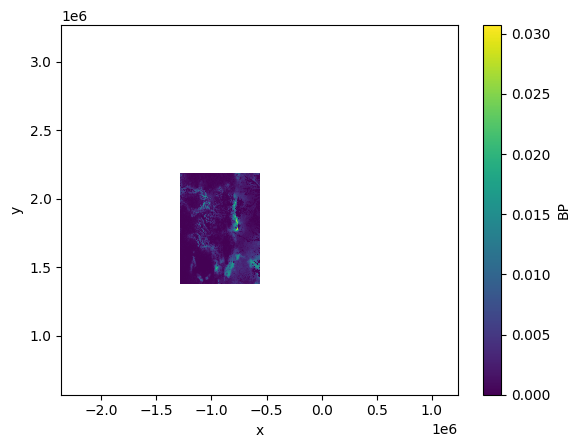

In [10]:
repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')
rtds = xr.open_zarr(session.store, consolidated=False, chunks={})[['BP']]
rtds.isel(y=slice(0, 90000), x=slice(0, 120000)).coarsen(x=10, y=10, boundary='trim').mean()[
    'BP'
].plot()